# General Linear Model 2 #

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze())
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()
  plt.show()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="C",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()


def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="C",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

In [4]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nn/5m7xhsdj28g92vn5kdvwz0680000gn/T/ipykernel_51331/3672203419.py:11: SyntaxWarning: invalid escape sequence '\s'
  plot_function(sigmoid, "\sigma", "z", (-10, 10))


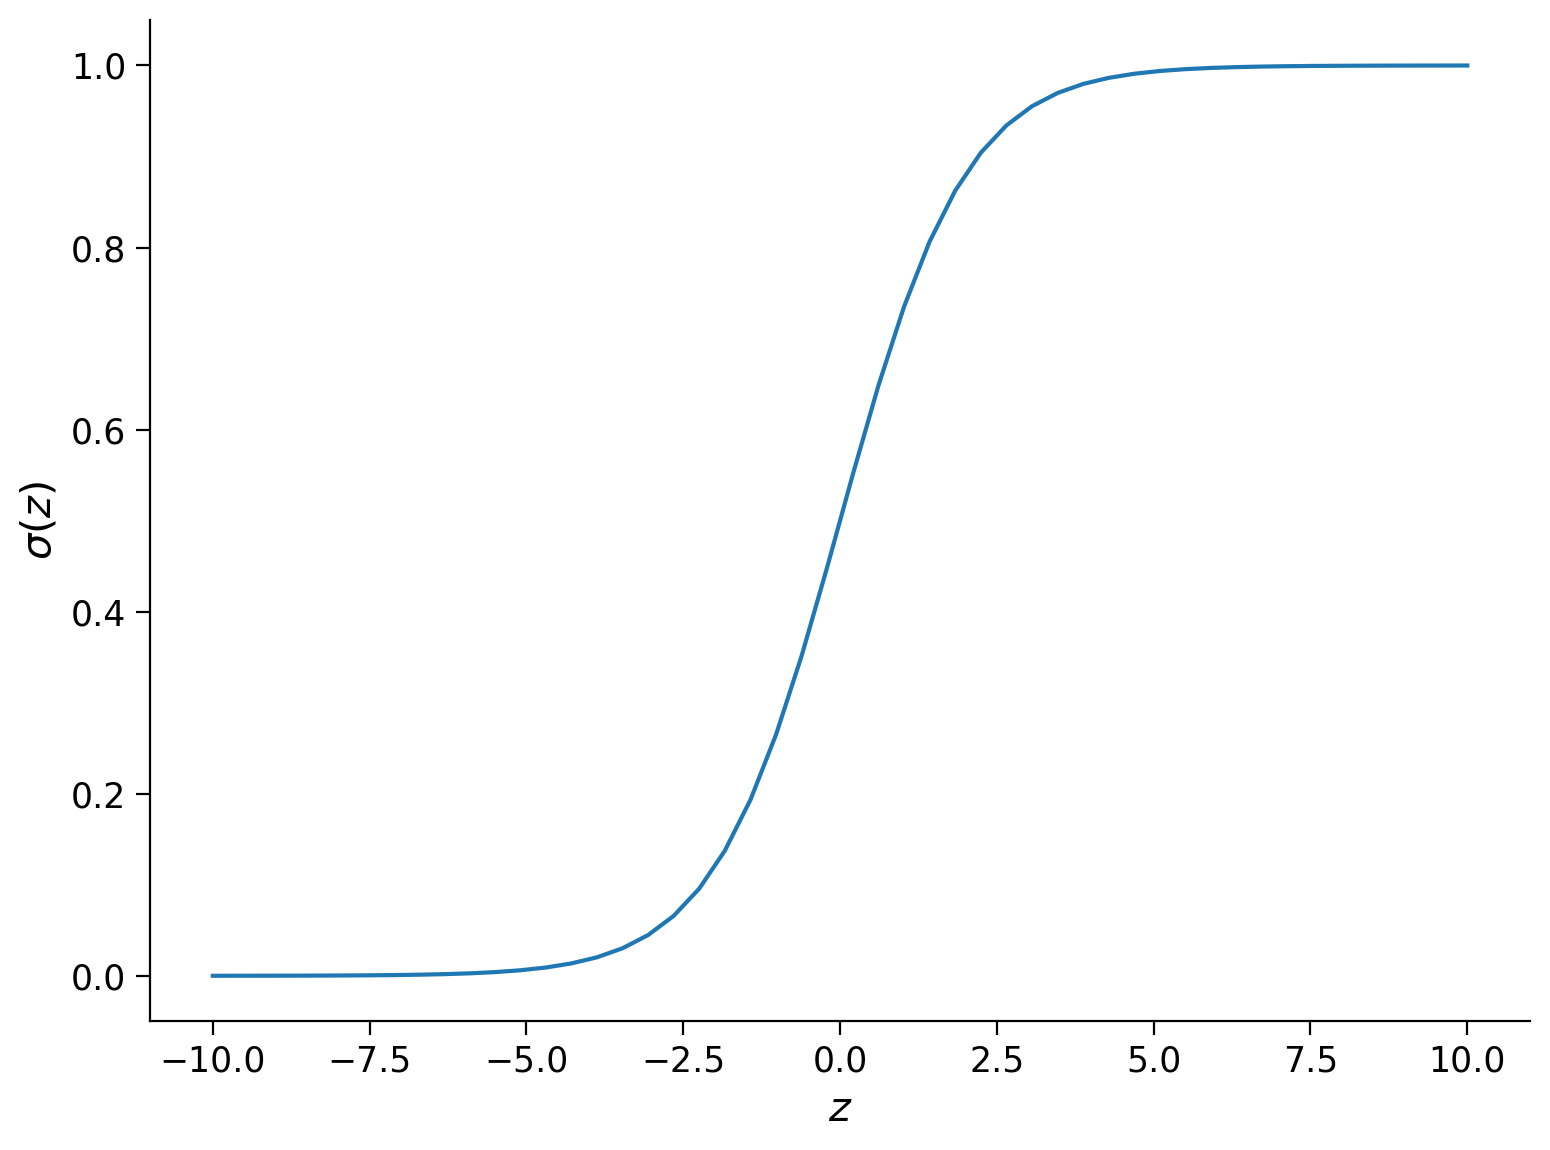

In [5]:
def sigmoid(z):
  """Return the logistic transform of z."""


  sigmoid = 1/(1 + np.exp(-z))

  return sigmoid


# Visualize
plot_function(sigmoid, "\sigma", "z", (-10, 10))

In [6]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

spikes (276, 691)
choices (276,)


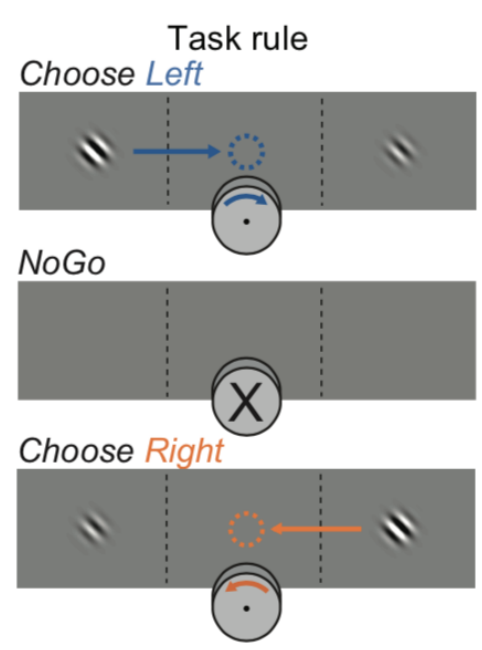

In [12]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/steinmetz-task.png")

In [7]:
y = data["choices"]
X = data["spikes"]

In [9]:
print(data['choices'])
print(data['spikes'])

[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
[[0.15 0.   0.1  ... 0.   0.   0.55]
 [0.2  0.05 0.25 ... 0.   0.   0.7 ]
 [0.1  0.   0.6  ... 0.   0.   0.55]
 ...
 [0.   0.   0.15 ... 0.   0.   0.5 ]
 [0.  

In [14]:
# Define the model
log_reg = LogisticRegression(penalty=None)

# Fit it to data
log_reg.fit(X, y)

LogisticRegression(penalty=None)

In [15]:
y_pred = log_reg.predict(X)

In [16]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """


  y_pred = model.predict(X)

  accuracy = np.sum(y_pred == y)/len(y)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


**Cross Validation**

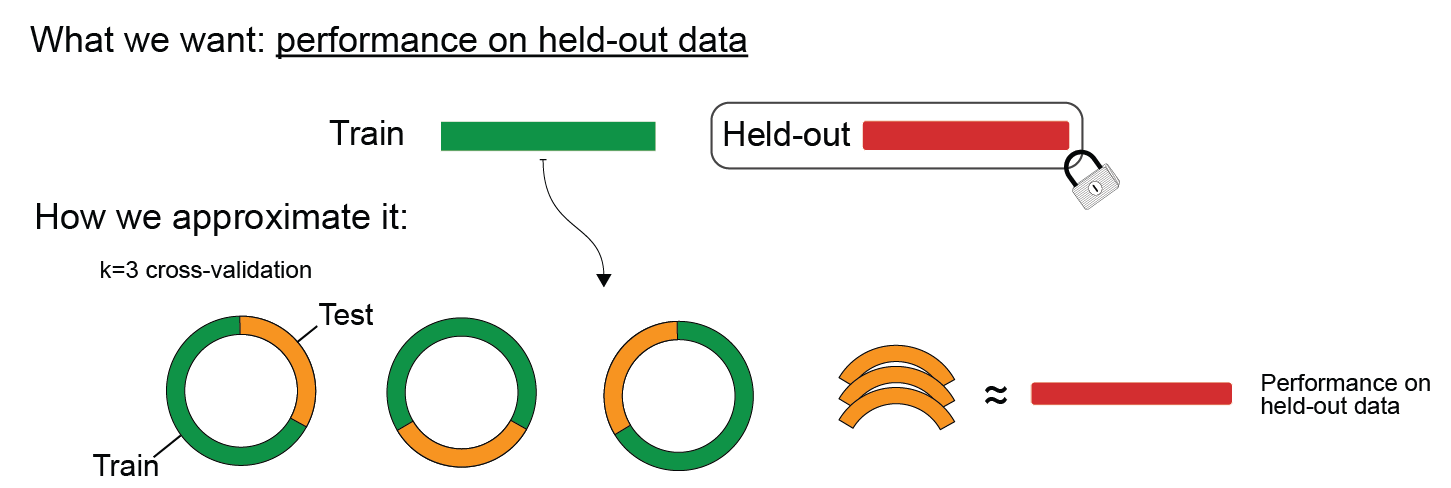

In [17]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/justCV-01.png")

In [18]:
accuracies = cross_val_score(LogisticRegression(penalty=None), X, y, cv=8)  # k=8 cross validation

cross_val_score takes a sklearn model like LogisticRegression, as well as your X and y data. 
It then retrains your model on test/train splits of X and y, and returns the test accuracy on each of the test sets.

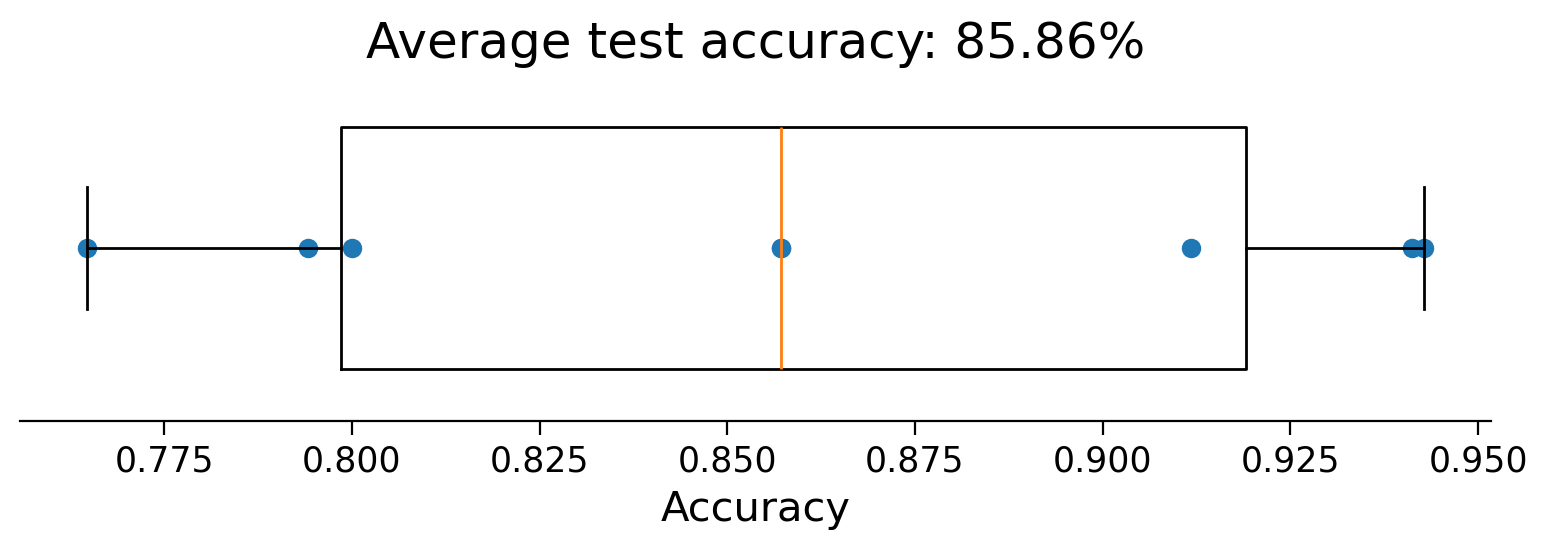

In [19]:
# @markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

In [20]:
print(X.shape)

(276, 691)


**Link to neuroscience:** Neuro data commonly has more features than samples. <br>
Having more neurons than independent trials is one example. <br>
In fMRI data, there are commonly more measured voxels than independent trials.

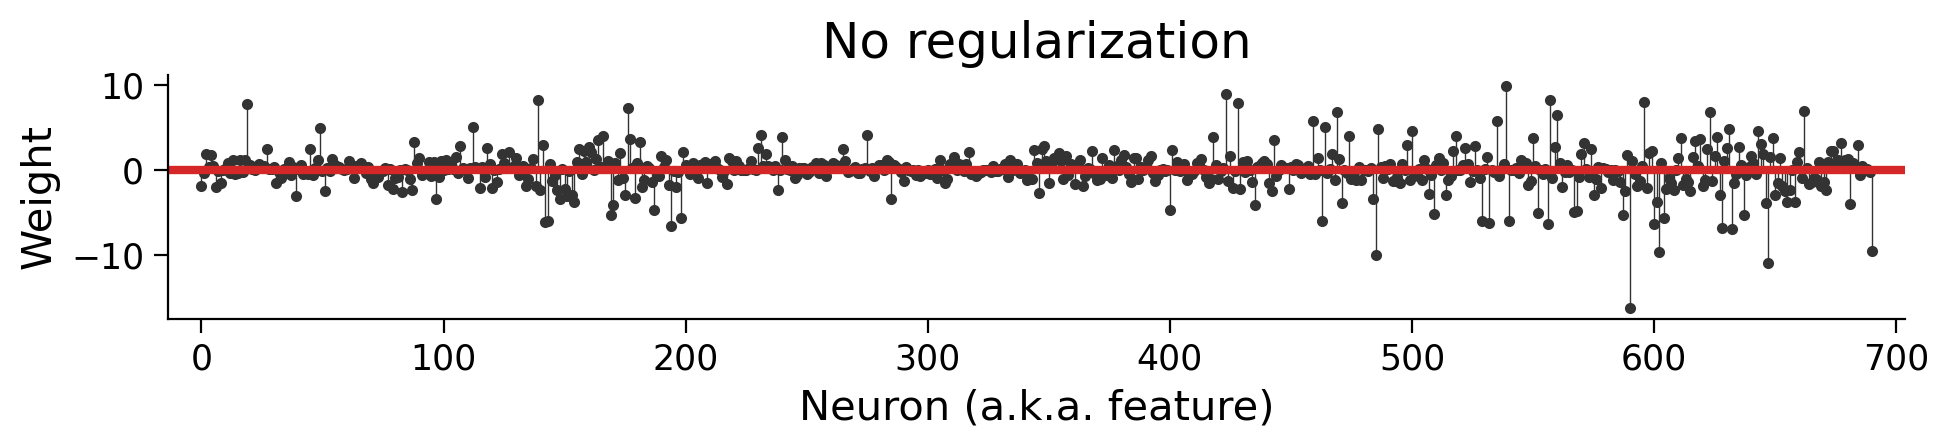

In [21]:
log_reg = LogisticRegression(penalty=None).fit(X, y)
plot_weights({"No regularization": log_reg})

L_2 Regularization

\begin{equation}
-\log\mathcal{L}'(\theta | X, y)= -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
\end{equation}

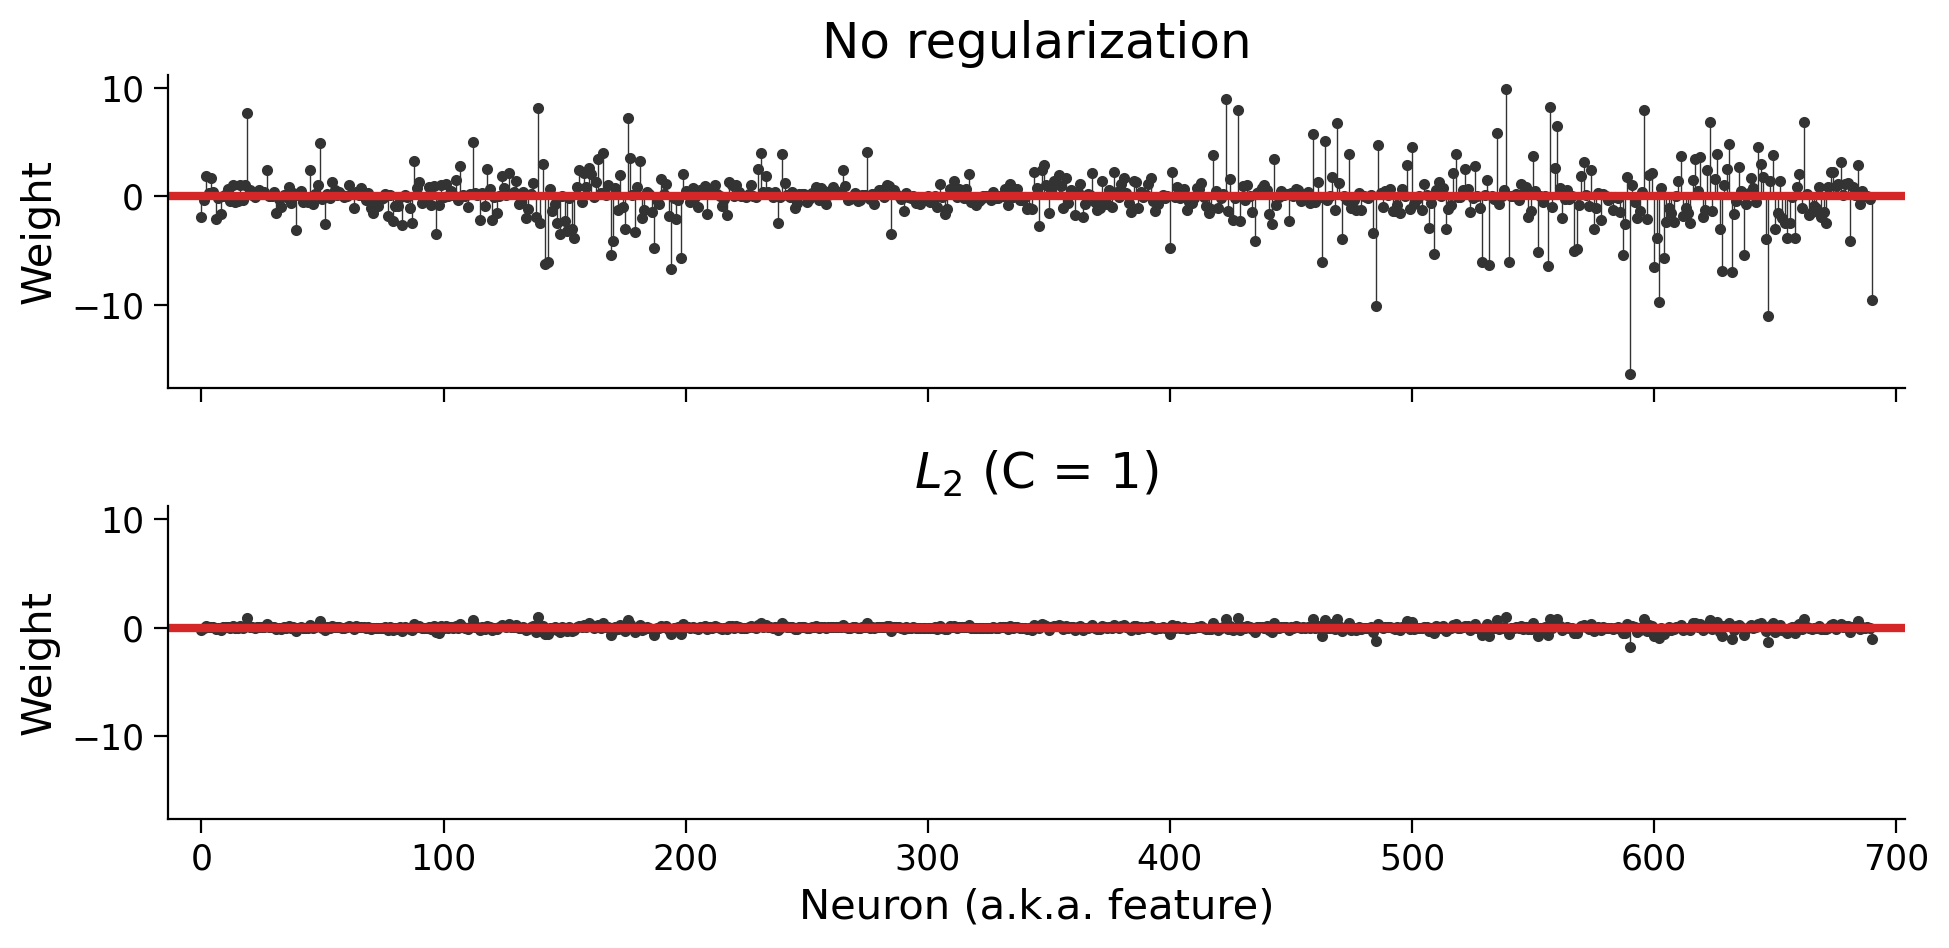

In [22]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models)

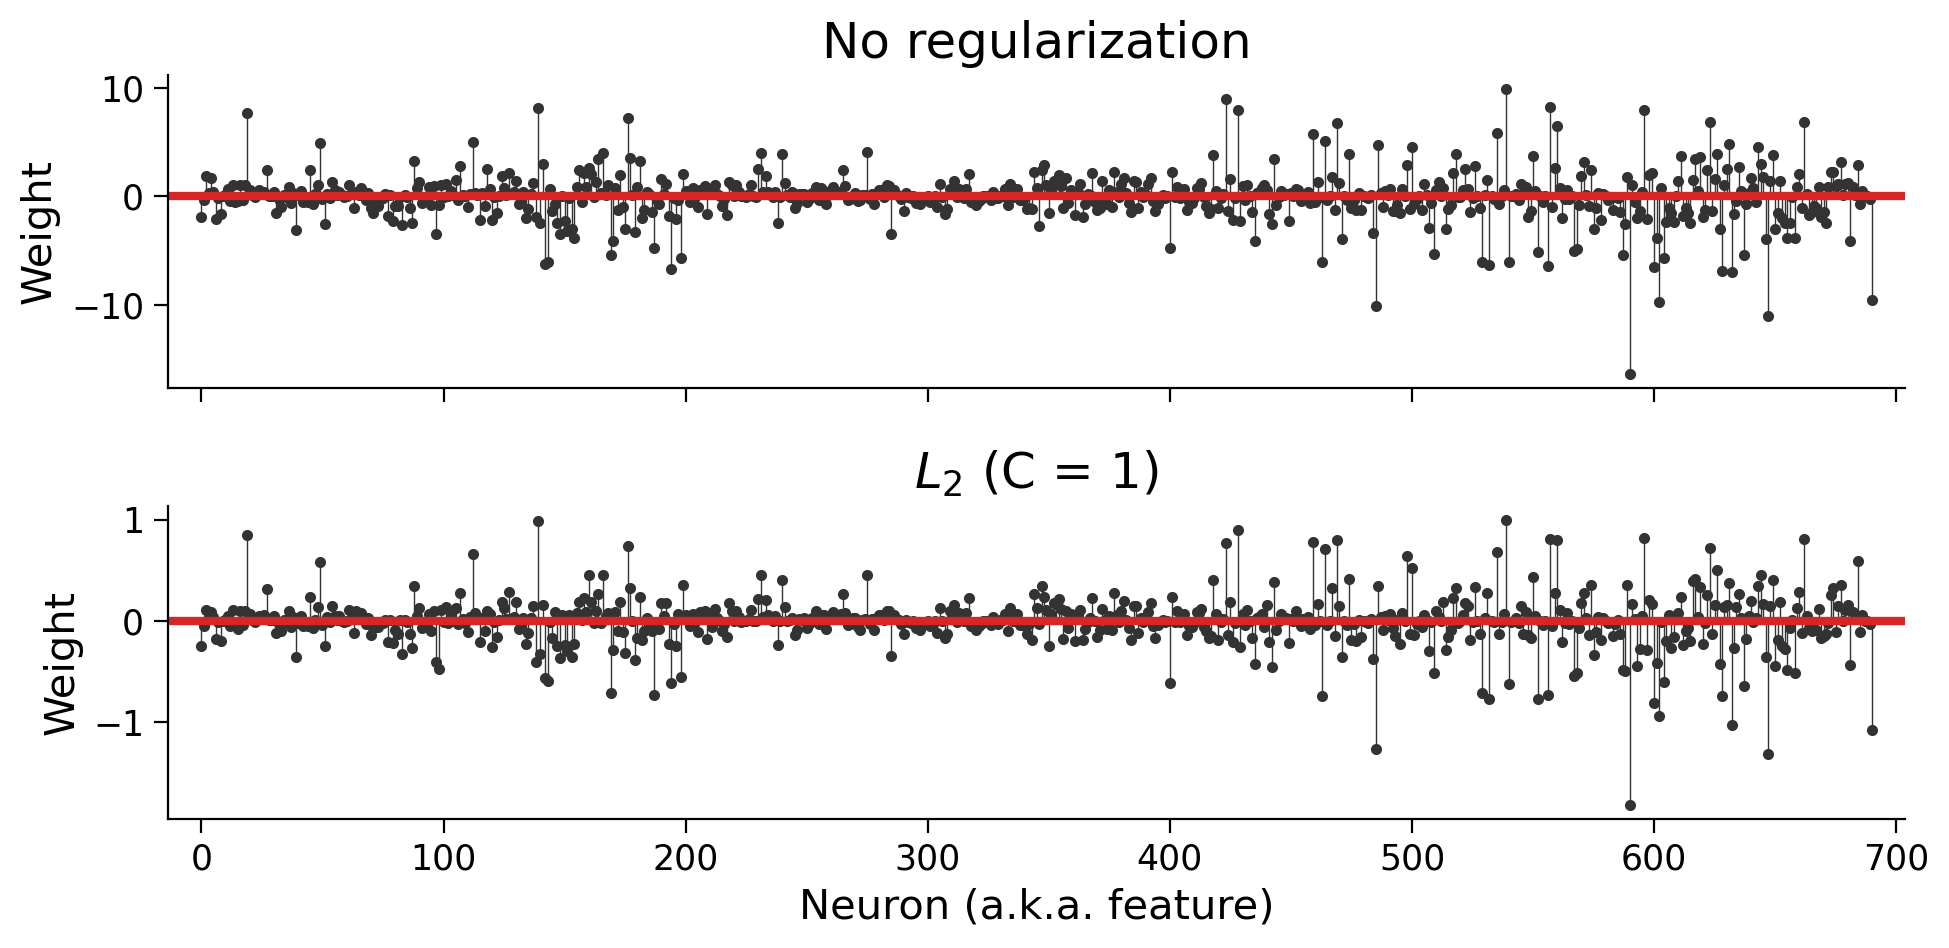

In [23]:
plot_weights(models, sharey=False)

In [24]:
# @markdown Execute this cell to enable the widget!

# Precompute the models so the widget is responsive
log_C_steps = 1, 11, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C = widgets.IntSlider(value=1, min=1, max=10, step=1)):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{{{log_C}}}$)": penalized_models[log_C]
  }
  plot_weights(models)


interactive(children=(IntSlider(value=1, description='log_C', max=10, min=1), Output()), _dom_classes=('widget…

L_1 Regularization

\begin{equation}
-\log\mathcal{L}'(\theta | X, y) = -\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i|\theta_i|
\end{equation}

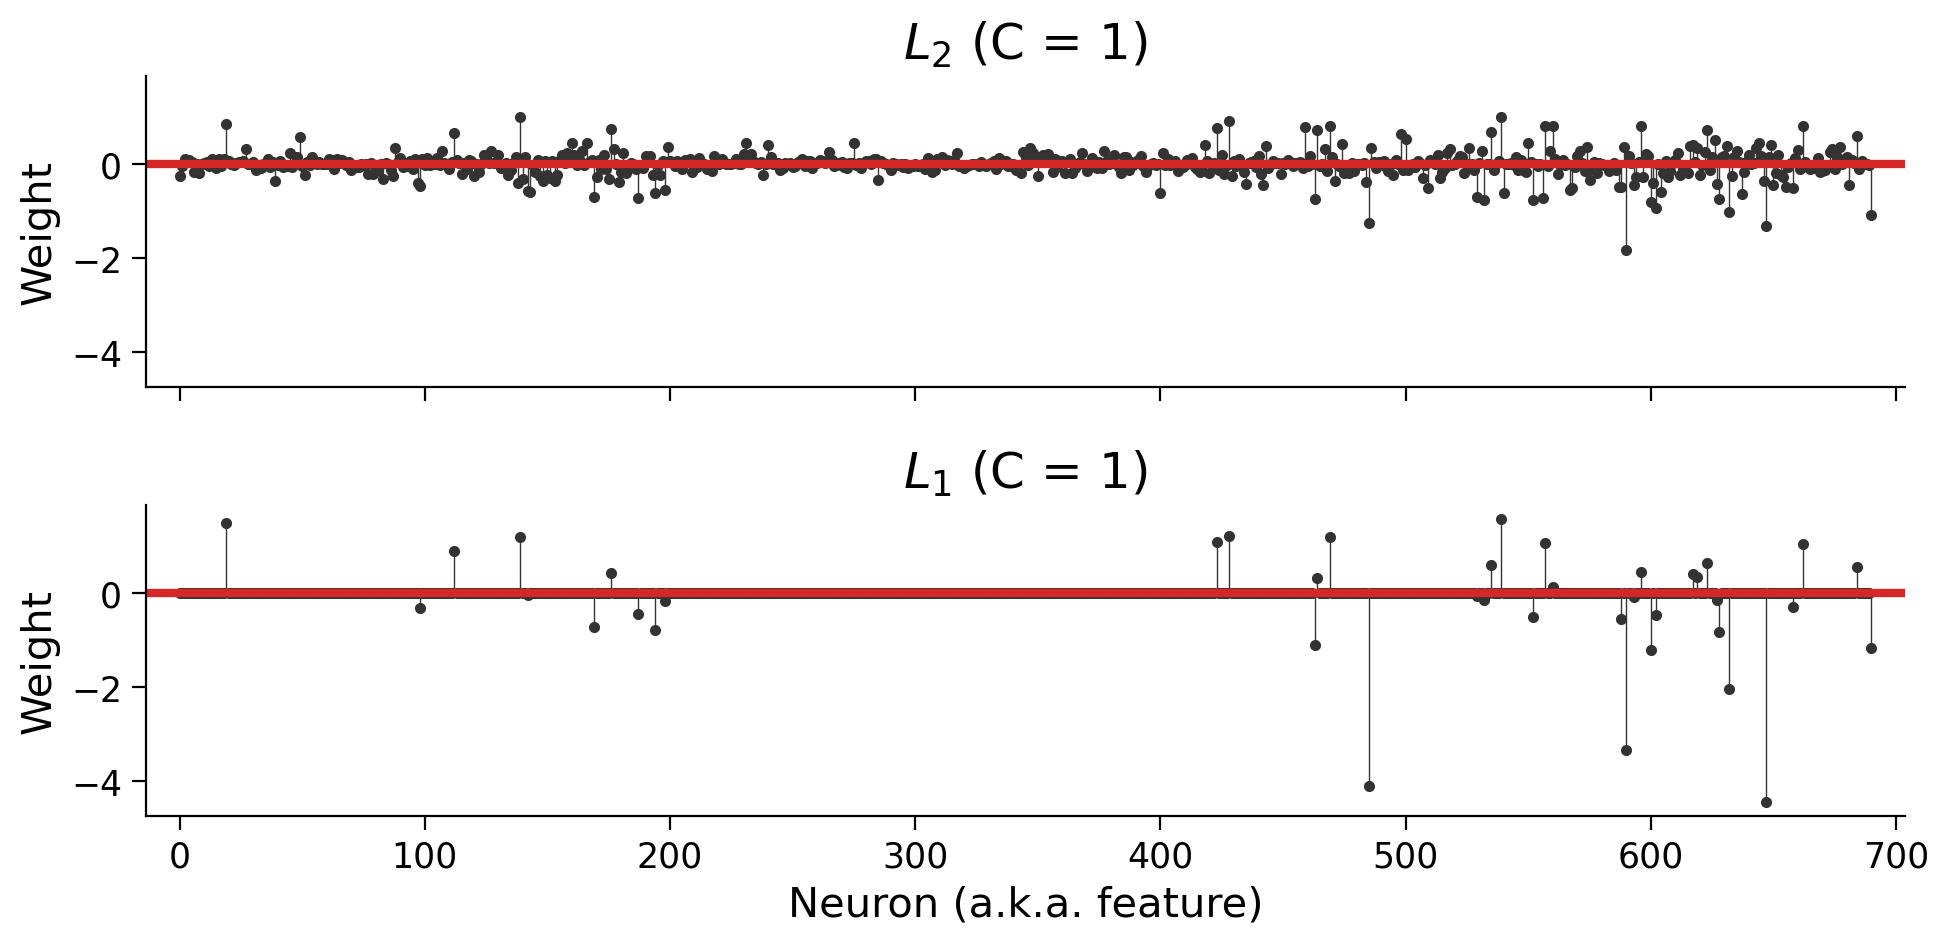

In [25]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

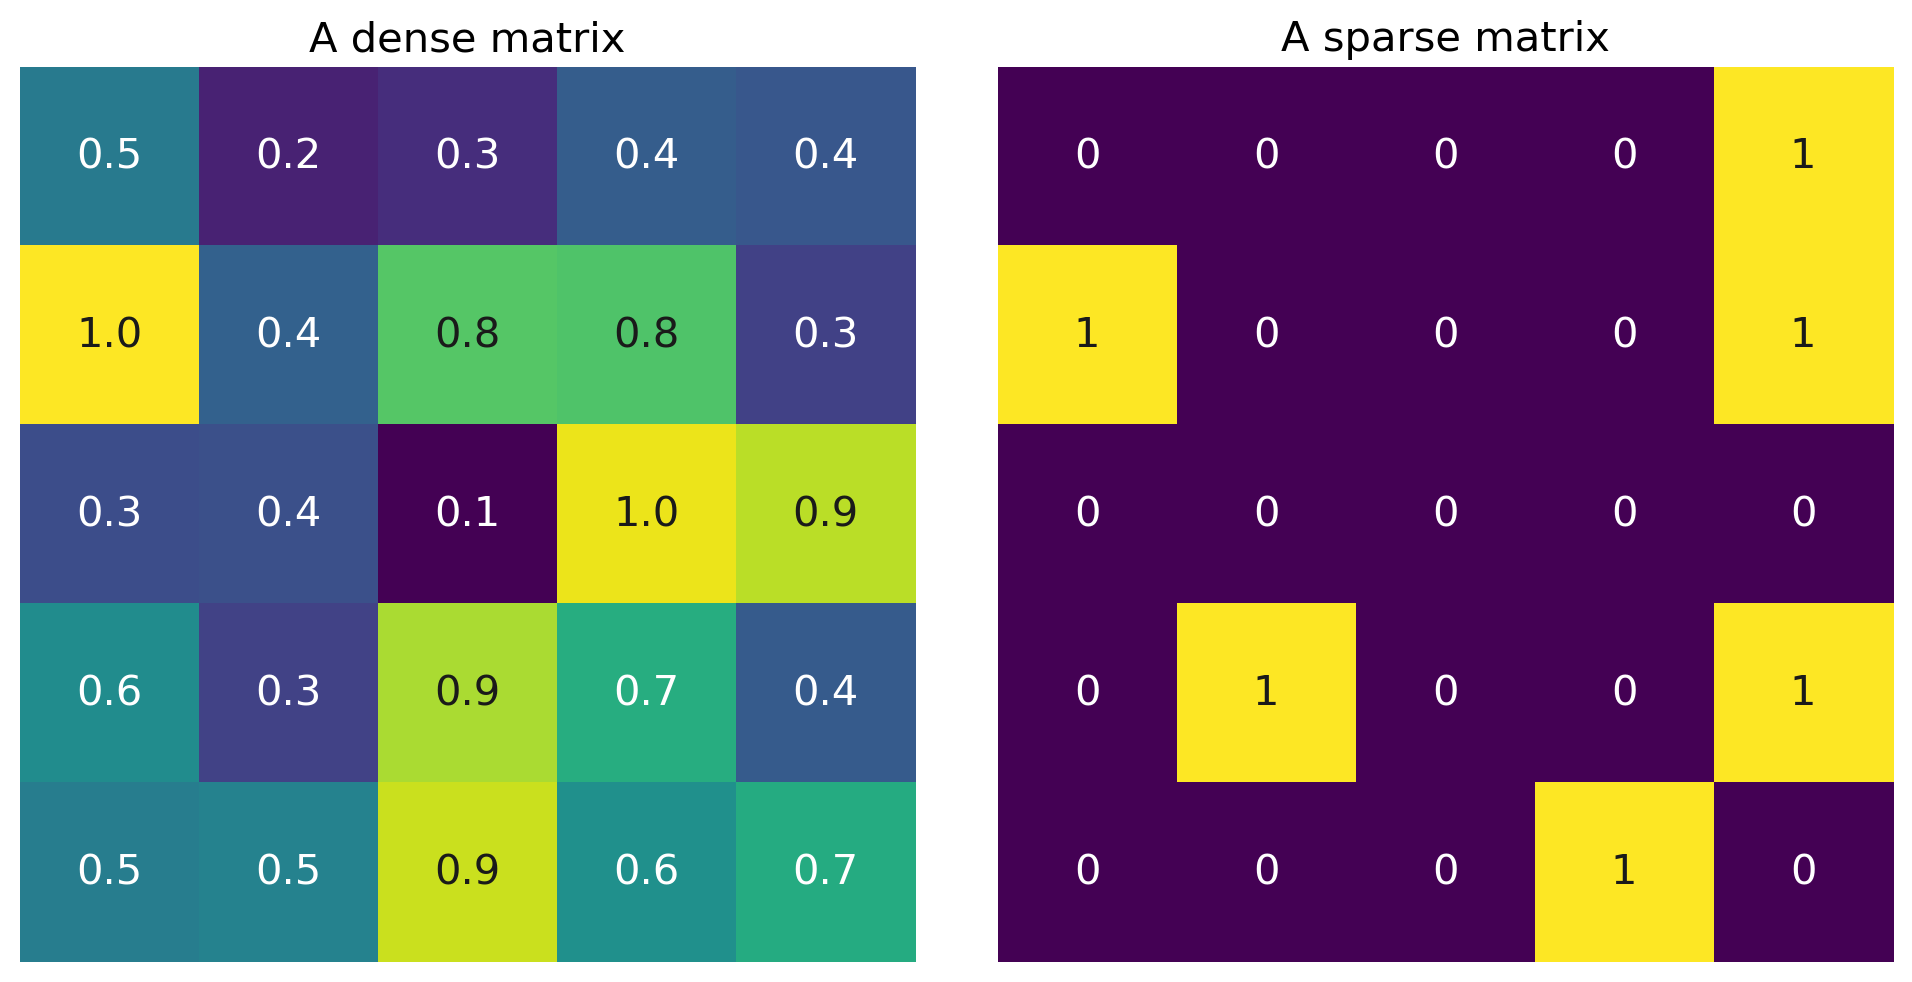

In [26]:
# @markdown Execute to plot a dense and a sparse matrix
np.random.seed(50)
n = 5
M = np.random.random((n, n))
M_sparse = np.random.choice([0, 1], size=(n, n), p=[0.8, 0.2])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axs[0].imshow(M)
axs[1].imshow(M_sparse)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title("A dense matrix", fontsize=15)
axs[1].set_title("A sparse matrix", fontsize=15)
text_kws = dict(ha="center", va="center")
for i in range(n):
  for j in range(n):
    iter_parts = axs, [M, M_sparse], ["{:.1f}", "{:d}"]
    for ax, mat, fmt in zip(*iter_parts):
      val = mat[i, j]
      color = ".1" if val > .7 else "w"
      ax.text(j, i, fmt.format(val), c=color, **text_kws)
plt.show()

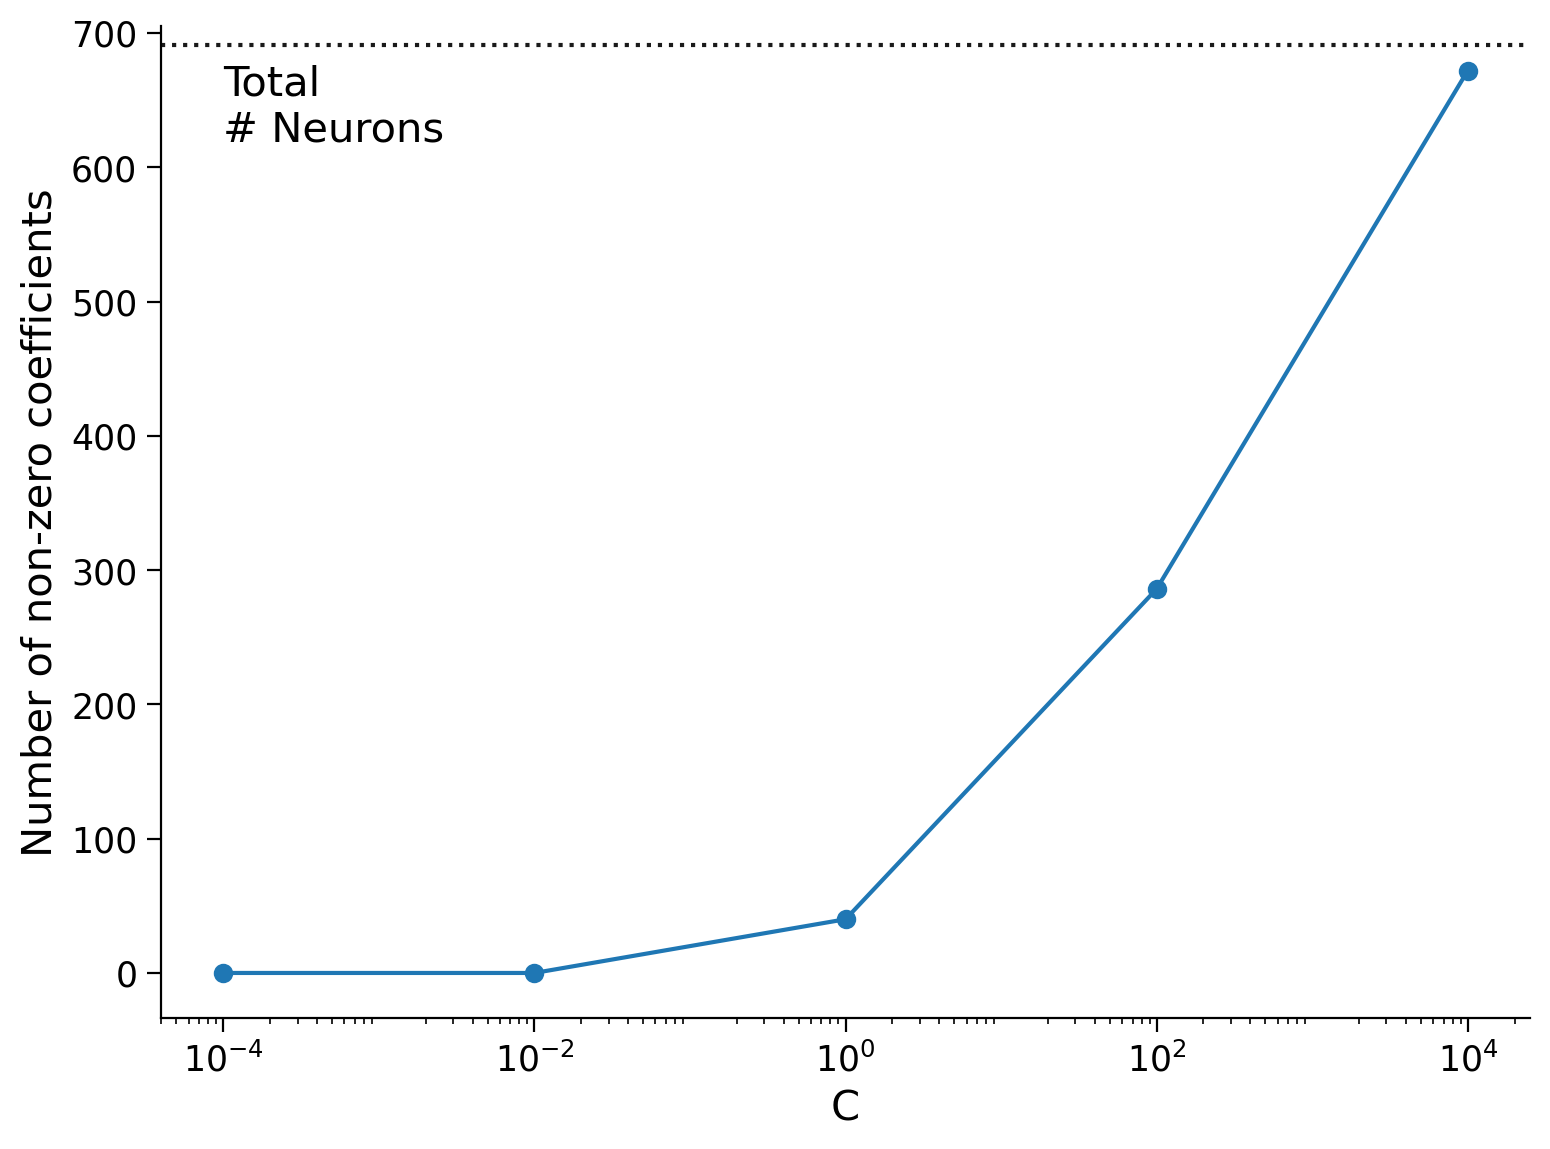

In [ ]:
#Evaluating Sparcity Values for different L1 models according to different C-Vlaues

def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """


  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)


    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.count_nonzero(coefs)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])

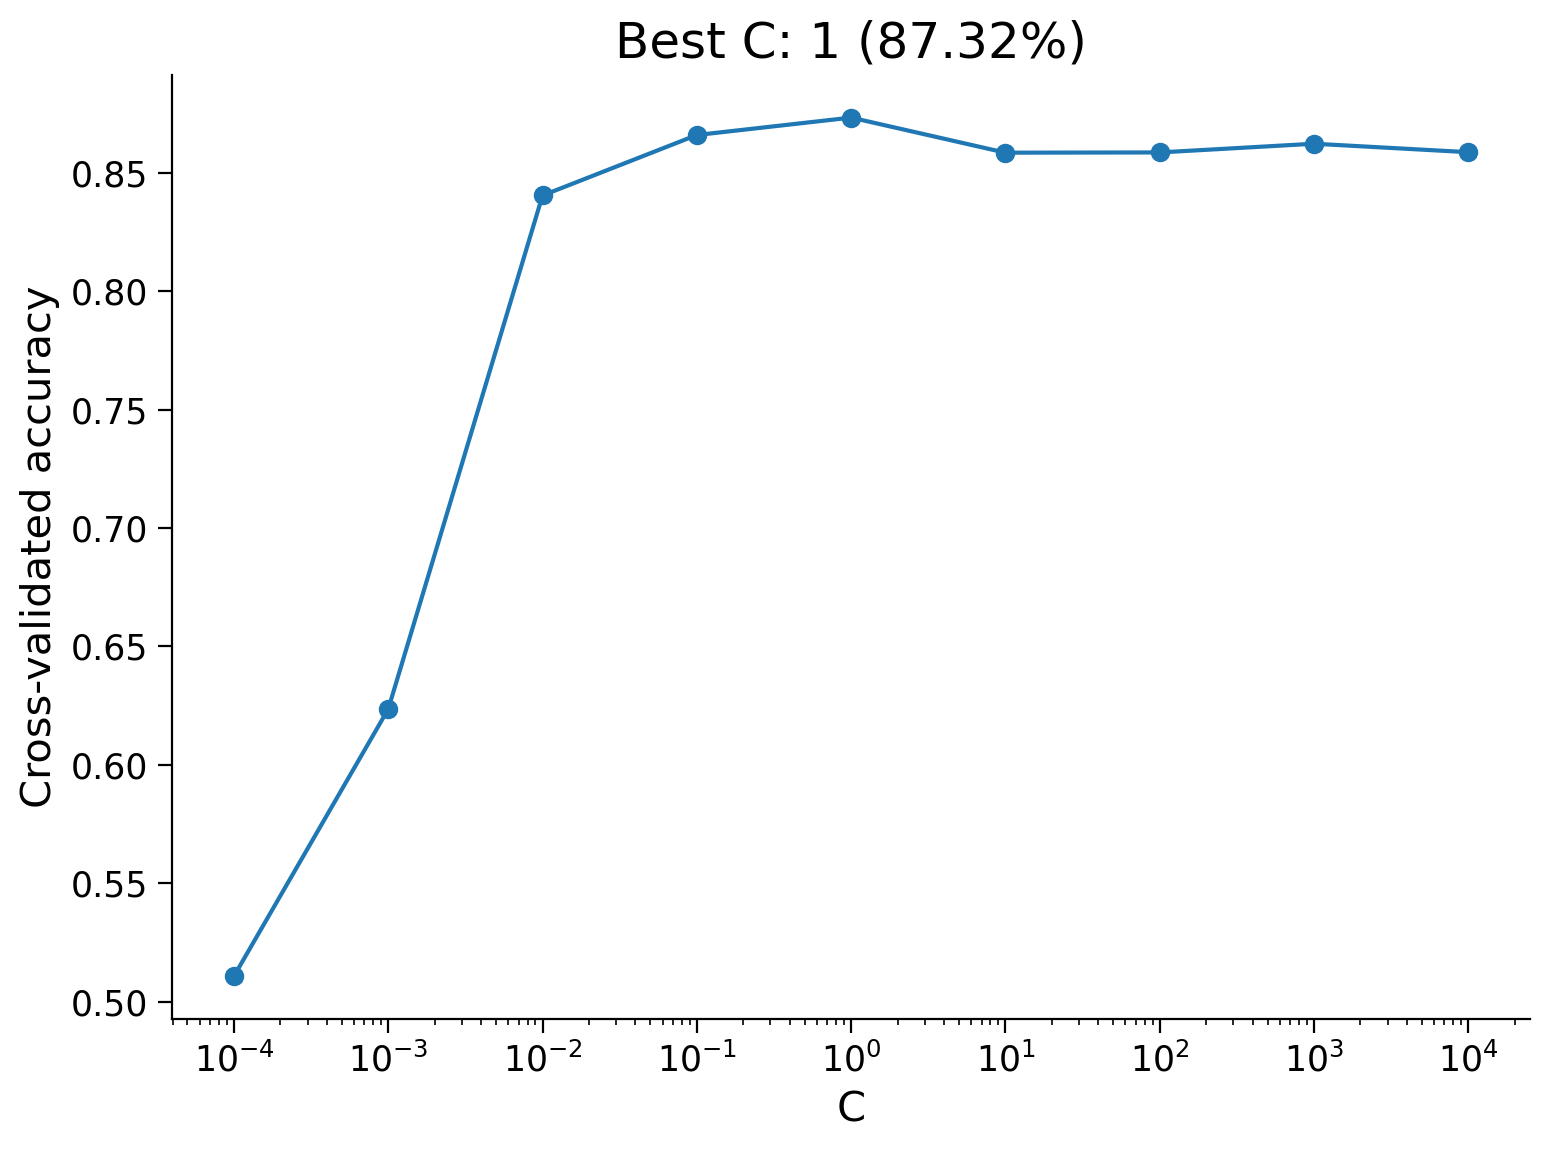

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


In [34]:
#Selecting the best L2 Model via Cross Validation

def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """


  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(np.mean(accs))

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies)
print(C_values)
